In [7]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
import numpy as np
import pickle
import re

mx.random.seed(1)
#ctx = mx.gpu(0)
ctx = mx.cpu(0)

In [8]:
with open("data/moliere_1_clean.txt") as f1:
    moliere_1 = f1.read()
with open("data/moliere_2_clean.txt") as f2:
    moliere_2 = f2.read()
with open("data/moliere_3_clean.txt") as f3:
    moliere_3 = f3.read()

In [9]:
text = moliere_1 #+ ' ' + moliere_2 + ' ' + moliere_3

In [10]:
len(text)

412476

In [11]:
text = text.replace('œ','oe')
text = text.replace('æ','ae')
text = text.replace('î','i')
text = text.replace('ï','i')
text = text.replace('º','')
text = text.replace('_','')
text = text.replace('ñ','n')
text = text.replace('λ','')
text = text.replace('ο','')
text = text.replace('ρ','')
text = text.replace('ς','')
text = text.replace('φ','')
text = text.replace('β','')
text = text.replace('ε','')
text = text.replace('ι','')

text = text.replace('\n',' ')

text = re.sub(r'( )+',' ',text) #remove multiple spaces

text[:200]

"Eh bien, Sabine, quel conseil me donnes-tu? Vraiment, il y a bien des nouvelles. Mon oncle veut résolûment que ma cousine épouse Villebrequin, et les affaires sont tellement avancées, que je crois qu'"

In [12]:
text = text#.lower().split()
character_list = list(set(text))
vocab_size = len(character_list)
character_list.sort()
print("Length of vocab: %s" % vocab_size)
print(character_list)

Length of vocab: 87
[' ', '!', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', '»', 'Ç', 'É', 'Ê', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'ô', 'ù', 'û']


In [13]:
character_dict = {}
for k, word in enumerate(character_list):
    character_dict[word] = k
#print(character_dict)

In [14]:
text_numerical = [character_dict[word] for word in text]

print(text_numerical[:20])
print("".join([character_list[idx] for idx in text_numerical[:20]]))

[25, 53, 0, 47, 54, 50, 59, 5, 0, 39, 46, 47, 54, 59, 50, 5, 0, 62, 66, 50]
Eh bien, Sabine, que


In [15]:
def one_hots(numerical_list, vocab_size=vocab_size):
    result = nd.zeros((len(numerical_list), vocab_size), ctx=ctx)
    for i, idx in enumerate(numerical_list):
        result[i, idx] = 1.0
    return result

In [16]:
def textify(embedding):
    result = ""
    indices = nd.argmax(embedding, axis=1).asnumpy()
    for idx in indices:
        result += character_list[int(idx)]
    return result

In [17]:
print(one_hots(text_numerical[:2]))


[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
<NDArray 2x87 @cpu(0)>


In [18]:
textify(one_hots(text_numerical[200:380]))

"ils eussent été mariés dès aujourd'hui, si vous n'étiez aimé; mais, comme ma cousine m'a confié le secret de l'amour qu'elle vous porte, et que nous nous sommes vues à l'extrémité "

In [19]:
seq_length = 64
# -1 here so we have enough characters for labels later
num_samples = (len(text_numerical) - 1) // seq_length
dataset = one_hots(text_numerical[:seq_length*num_samples]).reshape((num_samples, seq_length, vocab_size))
textify(dataset[0])

'Eh bien, Sabine, quel conseil me donnes-tu? Vraiment, il y a bie'

In [20]:
batch_size = 32
print('# of sequences in dataset: ', len(dataset))
num_batches = len(dataset) // batch_size
print('# of batches: ', num_batches)
train_data = dataset[:num_batches*batch_size].reshape((num_batches, batch_size, seq_length, vocab_size))
# swap batch_size and seq_length axis to make later access easier
train_data = nd.swapaxes(train_data, 1, 2)
print('Shape of data set: ', train_data.shape)

# of sequences in dataset:  6441
# of batches:  201
Shape of data set:  (201, 64, 32, 87)


In [21]:
labels = one_hots(text_numerical[1:seq_length*num_samples+1])
train_label = labels.reshape((num_batches, batch_size, seq_length, vocab_size))
train_label = nd.swapaxes(train_label, 1, 2)
print(train_label.shape)

(201, 64, 32, 87)


In [22]:
powerof2 = np.ceil(np.log2(vocab_size)).astype(int)
powerof2

7

In [23]:
num_inputs = vocab_size
num_hidden = 2**(powerof2+1)
num_outputs = vocab_size

num_hidden

256

In [24]:
num_inputs = vocab_size
num_hidden = 256
num_outputs = vocab_size

########################
#  Weights connecting the inputs to the hidden layer
########################
Wxz = nd.random_normal(shape=(num_inputs,num_hidden), ctx=ctx) * .01
Wxr = nd.random_normal(shape=(num_inputs,num_hidden), ctx=ctx) * .01
Wxh = nd.random_normal(shape=(num_inputs,num_hidden), ctx=ctx) * .01

########################
#  Recurrent weights connecting the hidden layer across time steps
########################
Whz = nd.random_normal(shape=(num_hidden,num_hidden), ctx=ctx)* .01
Whr = nd.random_normal(shape=(num_hidden,num_hidden), ctx=ctx)* .01
Whh = nd.random_normal(shape=(num_hidden,num_hidden), ctx=ctx)* .01

########################
#  Bias vector for hidden layer
########################
bz = nd.random_normal(shape=num_hidden, ctx=ctx) * .01
br = nd.random_normal(shape=num_hidden, ctx=ctx) * .01
bh = nd.random_normal(shape=num_hidden, ctx=ctx) * .01

########################
# Weights to the output nodes
########################
Why = nd.random_normal(shape=(num_hidden,num_outputs), ctx=ctx) * .01
by = nd.random_normal(shape=num_outputs, ctx=ctx) * .01

In [25]:
params = [Wxz, Wxr, Wxh, Whz, Whr, Whh, bz, br, bh, Why, by]

for param in params:
    param.attach_grad()

In [26]:
def softmax(y_linear, temperature=1.0):
    lin = (y_linear-nd.max(y_linear)) / temperature
    exp = nd.exp(lin)
    partition =nd.sum(exp, axis=0, exclude=True).reshape((-1,1))
    return exp / partition

In [27]:
def gru_rnn(inputs, h, temperature=1.0):
    outputs = []
    for X in inputs:
        z = nd.sigmoid(nd.dot(X, Wxz) + nd.dot(h, Whz) + bz)
        r = nd.sigmoid(nd.dot(X, Wxr) + nd.dot(h, Whr) + br)
        g = nd.tanh(nd.dot(X, Wxh) + nd.dot(r * h, Whh) + bh)
        h = z * h + (1 - z) * g

        yhat_linear = nd.dot(h, Why) + by
        yhat = softmax(yhat_linear, temperature=temperature)
        outputs.append(yhat)
    return (outputs, h)

In [28]:
def cross_entropy(yhat, y):
    return - nd.mean(nd.sum(y * nd.log(yhat), axis=0, exclude=True))

In [29]:
def average_ce_loss(outputs, labels):
    assert(len(outputs) == len(labels))
    total_loss = 0.
    for (output, label) in zip(outputs,labels):
        total_loss = total_loss + cross_entropy(output, label)
    return total_loss / len(outputs)

In [30]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [31]:
def sample(prefix, num_chars,include_prefix=True, temperature=1.0):
    #####################################
    # Initialize the string that we'll return to the supplied prefix
    #####################################
    string = prefix if include_prefix else ''

    #####################################
    # Prepare the prefix as a sequence of one-hots for ingestion by RNN
    #####################################
    prefix_numerical = [character_dict[char] for char in prefix]
    input = one_hots(prefix_numerical)

    #####################################
    # Set the initial state of the hidden representation ($h_0$) to the zero vector
    #####################################
    h = nd.zeros(shape=(1, num_hidden), ctx=ctx)
    c = nd.zeros(shape=(1, num_hidden), ctx=ctx)

    #####################################
    # For num_chars iterations,
    #     1) feed in the current input
    #     2) sample next character from from output distribution
    #     3) add sampled character to the decoded string
    #     4) prepare the sampled character as a one_hot (to be the next input)
    #####################################
    for i in range(num_chars):
        outputs, h = gru_rnn(input, h, temperature=temperature)
        choice = np.random.choice(vocab_size, p=outputs[-1][0].asnumpy())
        string += character_list[choice]
        input = one_hots([choice])
    return string

In [32]:
moving_loss = 0.0
learning_rate = 0.5

losses = []

In [33]:
'''
with open("output/saveState.pickle","rb") as open_file:
    dic = pickle.load(open_file)
params = dic['params']
'''

'\nwith open("output/saveState.pickle","rb") as open_file:\n    dic = pickle.load(open_file)\nparams = dic[\'params\']\n'

In [37]:
epochs = 1000

In [38]:
for e in range(epochs):
    ############################
    # Attenuate the learning rate by a factor of 2 every 100 epochs.
    ############################
    if ((e+1) % 100 == 0):
        learning_rate = learning_rate / 2.0
    h = nd.zeros(shape=(batch_size, num_hidden), ctx=ctx)
    for i in range(num_batches):
        data_one_hot = train_data[i]
        label_one_hot = train_label[i]
        with autograd.record():
            outputs, h = gru_rnn(data_one_hot, h)
            loss = average_ce_loss(outputs, label_one_hot)
            loss.backward()
        SGD(params, learning_rate)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        if (i == 0) and (e == 0):
            moving_loss = nd.mean(loss).asscalar()
        else:
            moving_loss = 0.99 * moving_loss + 0.01 * nd.mean(loss).asscalar()
        
    losses.append(moving_loss)

    if e%10 == 0:
        print("******** Epoch %s | Loss: %s" % (e, moving_loss))
        print(sample("Bonjou", 80, temperature=0.5))
        print(sample("Bonjou", 80, temperature=0.1))
        print(sample("Bonjour cher ami, je su", 80, temperature=0.1))
        
        with open("output/saveState.pickle","wb") as save_file:
            to_save = {'loss':losses,'params': params,'num_hidden':num_hidden,'character_list':character_list}
            pickle.dump(to_save, save_file)
            print('==== Model saved ====')
        
        print('')

******** Epoch 0 | Loss: 2.3294032391
Bonjour sn me tron de dois son tovent tont ca cous pa tont Qur de sur von phas ant déc
Bonjour de sous de sour de sour de sour de mous de sous le sous pant de sous de sous d
Bonjour cher ami, je sur cous de cous de sous de sous de sous de sour de sour de cous de sous de sour d
==== Model saved ====

******** Epoch 10 | Loss: 2.03988176092
Bonjoure a poir te fiène de visse moi dont ar de l'on mois dous de cour son sont mais 
Bonjour de son roit de vous de vous de vous de vous de pour de vous de vous de vous co
Bonjour cher ami, je sui sous de le vous de vous pour de vous de pour de vous de moi sous de vous de vo
==== Model saved ====

******** Epoch 20 | Loss: 1.86029428645
Bonjour dont le dout de la mes de moi sout pront vous mon sort des sarge un trout moi 
Bonjour de vous de vous de sout de vous de vous de coutre de son cout de vous de coupr
Bonjour cher ami, je suis pour l'avoir de vous de vous de vous de soit de vous de vous de la prond de v
==

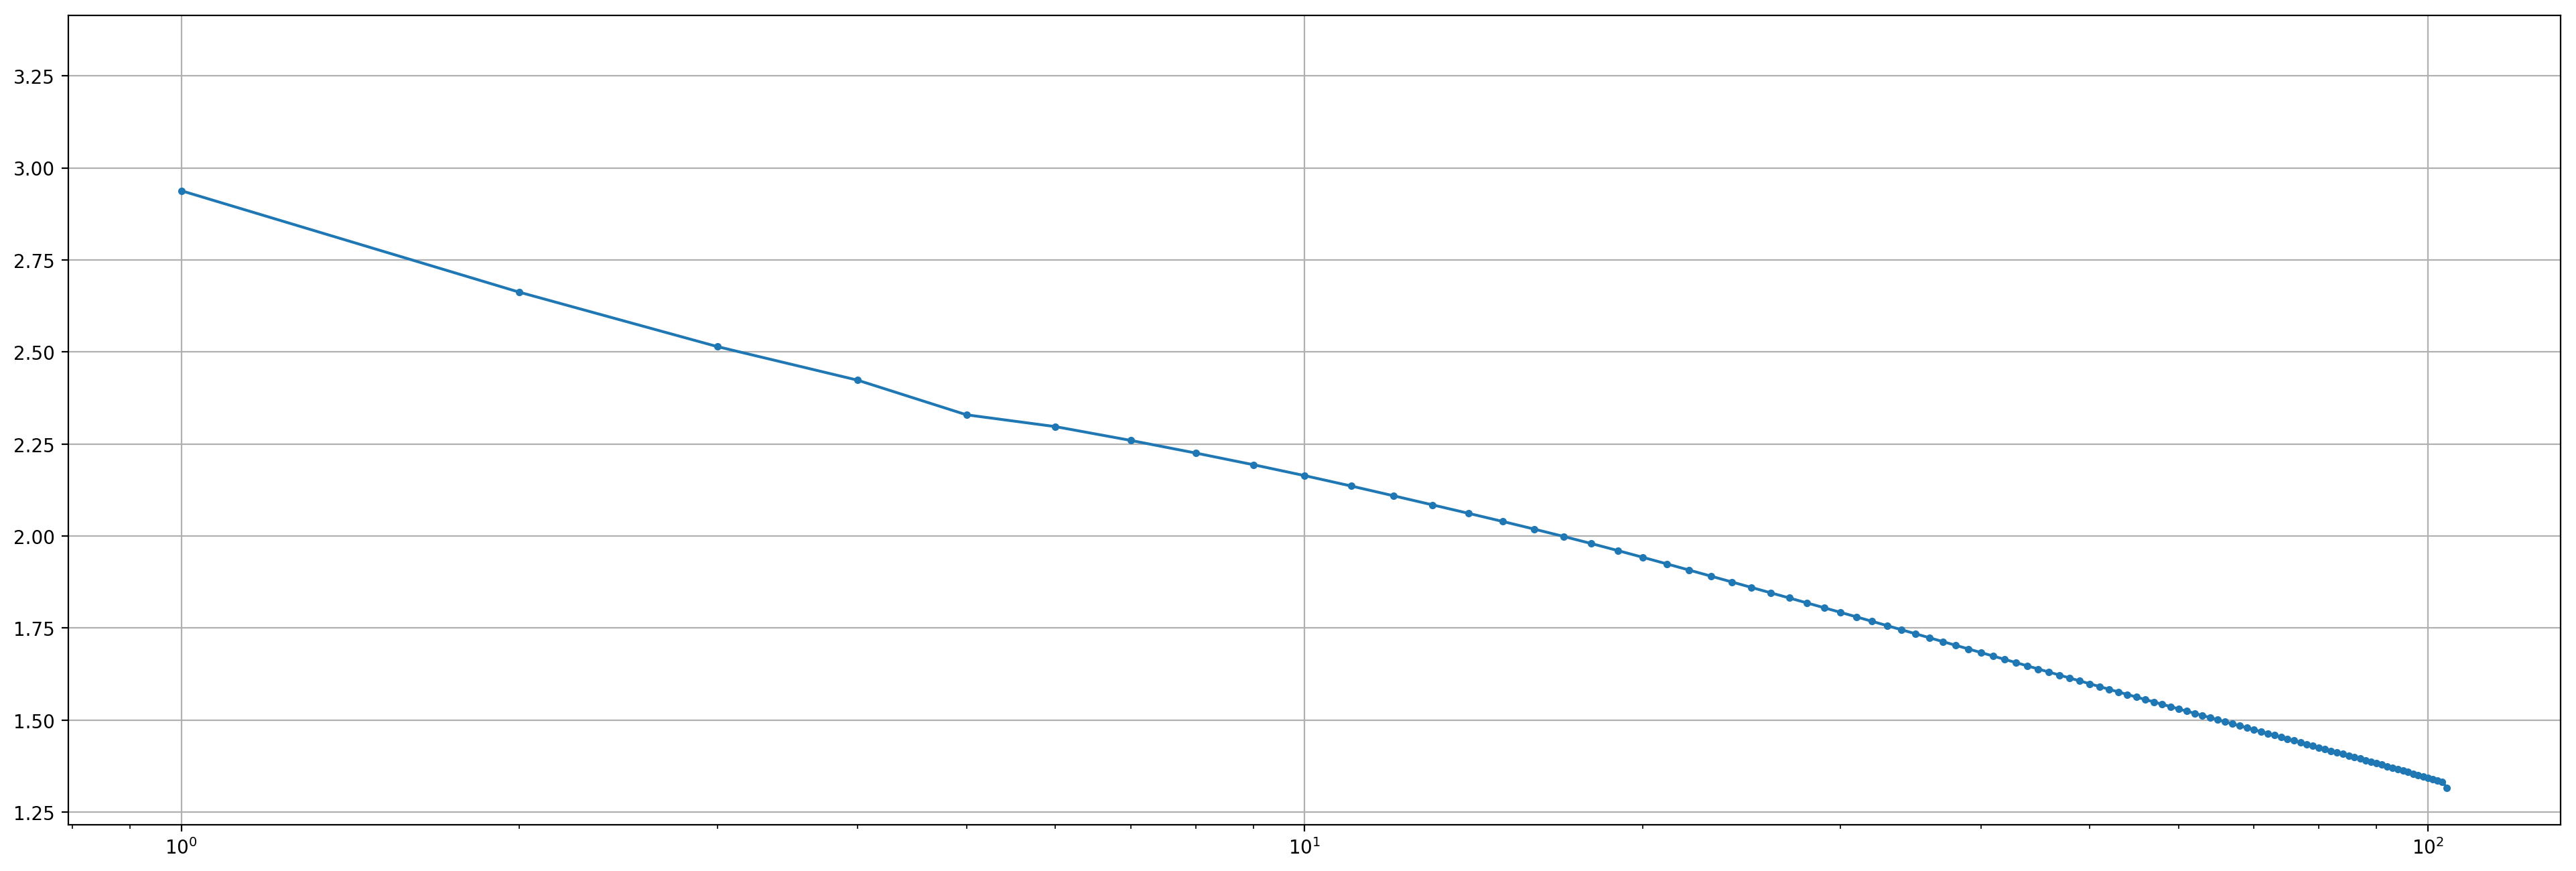

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(24, 8), dpi= 200)
plt.xscale('log')
#plt.yscale('log')
plt.plot(range(len(losses)),losses,'.-')
plt.grid()